# Impact of Aerosols on Cumulus clouds #1

In [ ]:
!apt-get install gfortran g++ gcc libnetcdf-dev libnetcdff-dev vim tmux &> /dev/null

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import netCDF4

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


## Compute  scattering properties of African Savanna smoke aerosol based on Dubovik et al. (2002)

In [ ]:
%cd /content/drive/Shareddrives/ZZhang_Teaching/Codes/Mie_code
!make

/content/drive/Shareddrives/ZZhang_Teaching/Codes/Mie_code
gfortran -O2 -g -o mie_single_size.exe mie_single_size.f90 MIEV0.o RDI1MACHmodule.o  ErrPack.o write_data.o -I/usr/include -L/usr/lib -lnetcdff -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-z,now -lnetcdf -lnetcdf
gfortran -O2 -g -o mie_single_size_driver.exe driver.f90 gamma_size.o REFWAT.o


In [ ]:
def write_mie_inputs():
  with open("filename.dat",'w') as f:
    f.write("smoke_particle_mie.nc")
  nwl =1
  wl = [0.50]
  nr = [1.51]
  ni = [0.0021]
  with open("wl_ref.dat",'w') as f:
    f.write('{0:2d} \n'.format(nwl))
    for i in range(nwl):
      f.write('{0:5.3f} {1:5.3f} {2:5.3e} \n'.format(wl[i],nr[i],ni[i]))
  nD = 1000
  D=np.logspace(-2,np.log10(20),nD)
  with open("size.dat",'w') as f:
    f.write('{:5d} \n'.format(nD))
    for i in range(nD):
      f.write('{0:7.3f} \n'.format(D[i]))


write_mie_inputs()

In [ ]:
def write_mie_inputs():
  with open("filename.dat",'w') as f:
    f.write("cloud_particle_mie2.nc")
  nwl =1
  wl = [0.50]
  nr = [1.51]
  ni = [0.0021]
  with open("wl_ref.dat",'w') as f:
    f.write('{0:2d} \n'.format(nwl))
    for i in range(nwl):
      f.write('{0:5.3f} {1:5.3f} {2:5.3e} \n'.format(wl[i],nr[i],ni[i]))
  nD = 1000
  D=np.logspace(-2,np.log10(20),nD)
  with open("size.dat",'w') as f:
    f.write('{:5d} \n'.format(nD))
    for i in range(nD):
      f.write('{0:7.3f} \n'.format(D[i]))


write_mie_inputs()

In [ ]:
import subprocess
import sys
result = subprocess.run( "./mie_single_size.exe",capture_output=True, text=True)

In [ ]:
class Mie_Sca_Prop():
  def __init__(self,fn):
    ncf = netCDF4.Dataset(fn,'r')
    self.D      =np.array(ncf.variables['Diameter']) #actually size parameter
    self.Nr     =np.array(ncf.variables['Refr_real']) #real refractive indexes
    self.Ni     =np.array(ncf.variables['Refr_img']) #imaginary refractive indexes
    self.Ang    =np.array(ncf.variables['PhaseFunctionAngle']) #Scattering angle
    self.SSA    =np.array(ncf.variables['SingleScatteringAlbedo']) #single scattering albedo
    self.Qe     =np.array(ncf.variables['ExtinctionEfficiency']) #Extinction effciency
    self.Asy    =np.array(ncf.variables['AsymmetryFactor']) #Asymmetry factor
    self.P11    =np.array(ncf.variables['P11']) #phase functions
    self.P12    =np.array(ncf.variables['P12'])*self.P11
    self.P33    =np.array(ncf.variables['P33'])*self.P11
    self.P34    =np.array(ncf.variables['P34'])*self.P11

    print('dimensions of variables')
    print('Diameter',self.D.shape)
    print('Refractive index',self.Nr.shape)
    print('Scattering Angle',self.Ang.shape)
    print('Qe, SSA, Asy shape',self.Qe.shape)
    print('P11 shape', self.P11.shape)

  def plot(self):
    fig,ax=plt.subplots()
    ax.plot(self.D,self.Qe)
    ax.set_xscale('log')
    ax.set_xlabel('Diameter')
    ax.set_ylabel('Qe')

    fig,ax=plt.subplots()
    ax.plot(self.D,self.SSA[:,0])
    ax.plot(self.D,self.SSA[:,-1])
    ax.set_xscale('log')
    ax.set_xlabel('Diameter')
    ax.set_ylabel('SSA')

    fig,ax=plt.subplots()
    ax.plot(self.Ang,self.P11[0,1,:])
    #ax.set_yscale('log')
    ax.set_xlabel('Angle')
    ax.set_ylabel('P11')

    fig,ax=plt.subplots()
    ax.plot(self.Ang,self.P12[0,1,:])
    ax.set_xlabel('Angle')
    ax.set_ylabel('P12')


## Average the single scattering properties over particle size distribution

In [ ]:
class lognormal_dV_dlnr():
  def __init__(self,r,rv,Cv,sigma,plot_figure=True):
    self.r=r
    self.Cv=Cv
    self.rv=rv
    self.sigma=sigma
    self.nmode=Cv.size
    self.dV_dlnr = np.zeros_like(r)
    for i in range(self.nmode):
      self.dV_dlnr+=Cv[i]/np.sqrt(2*np.pi)/sigma[i]* \
                    np.exp(-(np.log(r)-np.log(rv[i]))**2/2/sigma[i])

    self.dN_dlnr = self.dV_dlnr/(4/3*np.pi*self.r**3) # convert dV_dlnr to dN_dlnr
    self.dA_dlnr = self.dV_dlnr/(4/3*self.r)          # convert dV_dlnr to dA_dlnr
    if plot_figure:
      fig,ax=plt.subplots(figsize=(12, 8))
      ax.plot(self.r,self.dV_dlnr,label="Urban aerosol")
      plt.legend()
      ax.set_xlabel(r'radius [$\mu m$]',fontsize='x-large')
      ax.set_ylabel(r'PSD dN_dlnr',fontsize='x-large')
      ax.set_xscale('log')

      fig,ax=plt.subplots()
      ax.plot(self.r,self.dA_dlnr)
      ax.set_xlabel(r'radius [$\mu m$]')
      ax.set_ylabel(r'PSD dA_dlnr')
      ax.set_xscale('log')

      fig,ax=plt.subplots(figsize=(12, 8))
      ax.plot(self.r,self.dN_dlnr,label="Urban aerosol")
      plt.legend()
      ax.set_xlabel(r'radius [$\mu m$]',fontsize='x-large')
      ax.set_ylabel(r'PSD dN_dlnr',fontsize='x-large')
      ax.set_xscale('log')


In [ ]:
class gamma_PSD():
  def __init__(self,r,reff,Nc=1.0,veff=0.1,plot_figure=True):
    self.r=r
    self.reff=reff
    self.veff=veff
    e1 = (1-3*veff)/veff
    e2 = reff*veff
    self.dN_dr= np.power(r,e1)*np.exp(-r/e2)
    #normalize PSD to Nc
    C0=np.trapz(self.dN_dr,r)
    self.dN_dr/=C0/Nc
    if plot_figure:
      fig,ax=plt.subplots(figsize=(12, 8))
      ax.plot(self.r,self.dN_dr,label="Cloud")
      plt.legend()
      ax.set_xlabel(r'radius [$\mu m$]',fontsize='x-large')
      ax.set_ylabel(r'PSD dN_dlnr',fontsize='x-large')
      ax.set_xscale('log')


In [ ]:
Smoke_SS = Mie_Sca_Prop('smoke_particle_mie.nc')

dimensions of variables
Diameter (1000,)
Refractive index (1,)
Scattering Angle (1801,)
Qe, SSA, Asy shape (1000, 1)
P11 shape (1000, 1, 1801)


In [ ]:
Cloud_SS = Mie_Sca_Prop('cloud_particle_mie2.nc')

dimensions of variables
Diameter (1000,)
Refractive index (1,)
Scattering Angle (1801,)
Qe, SSA, Asy shape (1000, 1)
P11 shape (1000, 1, 1801)


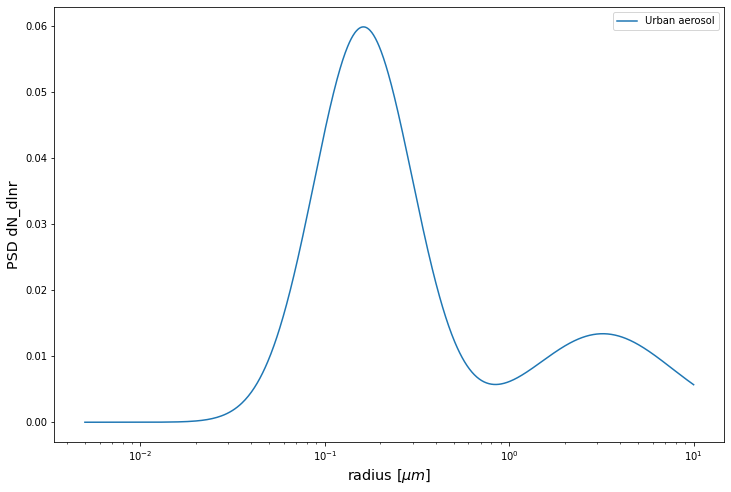

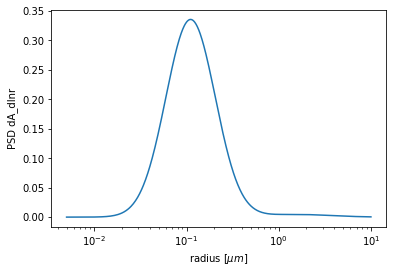

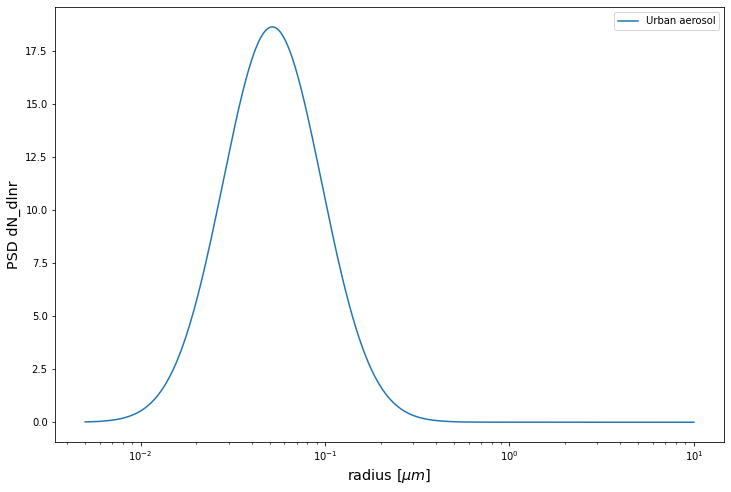

In [ ]:
tau440=0.38
rv=np.array([0.12+0.11*tau440,3.03+0.49*tau440])
Cv=np.array([0.15*tau440,0.01 + 0.04*tau440])
sigma=np.array([0.38,0.75])
Smoke_PSD = lognormal_dV_dlnr(Smoke_SS.D/2.0,rv,Cv,sigma)

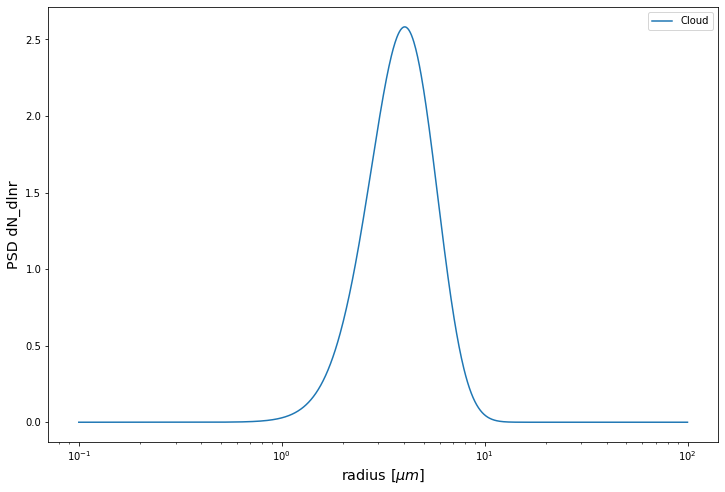

In [ ]:
r=np.logspace(-1,2,1000)
reff=5.77
Nc=10.0
#cloud_PSD = gamma_PSD(Cloud_SS.D/2.0,reff,Nc=Nc)
cloud_PSD = gamma_PSD(r,reff,Nc=Nc)
# sanity check to see if the effective radius is the input reff
#r0=np.trapz(cloud_PSD.dN_dr,r)
#r3=np.trapz(r**3*cloud_PSD.dN_dr,r)
#r2=np.trapz(r**2*cloud_PSD.dN_dr,r)
#print('reff',r3/r2)
#print('Nc',r0)

0.98497254
0.64374036
(1801,)


(0.0, 180.0)

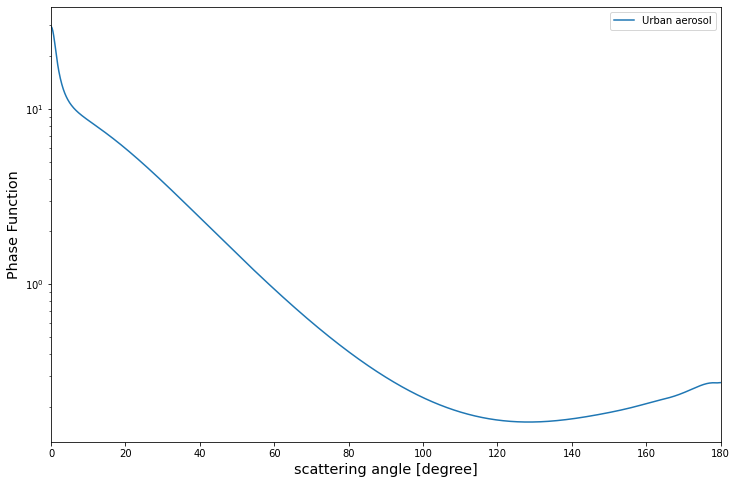

In [ ]:
lnr=np.log(Smoke_SS.D/2)
smoke_ext = np.trapz(Smoke_SS.Qe[:,0]*Smoke_PSD.dA_dlnr,lnr)
smoke_sca = np.trapz(Smoke_SS.SSA[:,0]*Smoke_SS.Qe[:,0]*Smoke_PSD.dA_dlnr,lnr)
smoke_alb = smoke_sca/smoke_ext
smoke_P11 = np.zeros_like(Smoke_SS.Ang)
for i in range(Smoke_SS.Ang.size):
  smoke_P11[i]=np.trapz(Smoke_SS.P11[:,0,i]*Smoke_SS.SSA[:,0]*Smoke_SS.Qe[:,0]*Smoke_PSD.dA_dlnr,lnr)/smoke_sca

# re-normalize P11
C = -np.trapz(smoke_P11, np.cos(np.radians(Smoke_SS.Ang)))/2
smoke_P11/=C

print(smoke_alb)
print(smoke_ext)
print(smoke_P11.shape)
fig,ax=plt.subplots(figsize=(12, 8))
ax.plot(Smoke_SS.Ang,smoke_P11,label="Urban aerosol")
plt.legend()
ax.set_yscale('log')
ax.set_xlabel('scattering angle [degree]',fontsize='x-large')
ax.set_ylabel('Phase Function',fontsize='x-large')
ax.set_xlim([0,180])
#ax.set_title('Polarized phase function vs scattering angle',fontsize='x-large')

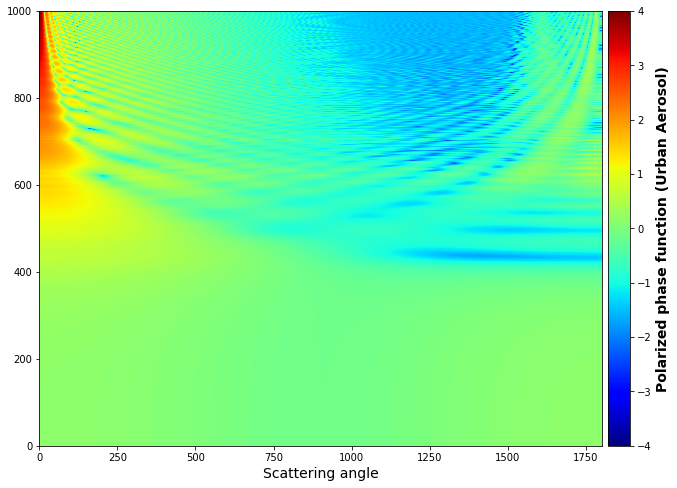

In [ ]:
fig,ax=plt.subplots(figsize=(12, 8))
#cf2 = ax.imshow(np.log10(Smoke_SS.P11[:,0,:]),cmap='jet')
cf3 = ax.pcolormesh(np.log10(Cloud_SS.P11[:,0,:]),cmap='jet', vmin = -4, vmax = 4)
cbar = fig.colorbar(cf3, ax=ax, pad=0.01)
cbar.set_label(label=r"Polarized phase function (Urban Aerosol)", size=14, weight="bold")
#ax.set_ylabel("Polarized phase function", fontsize=14)
ax.set_xlabel('Scattering angle', fontsize=14)
#plt.title("Polarized phase function vs scattering angle", fontsize=16)
#fig.colorbar(cf2,ax=ax)
plt.show()

[3.1286178]
[0.3120679]
(1, 1801)
(1801,)


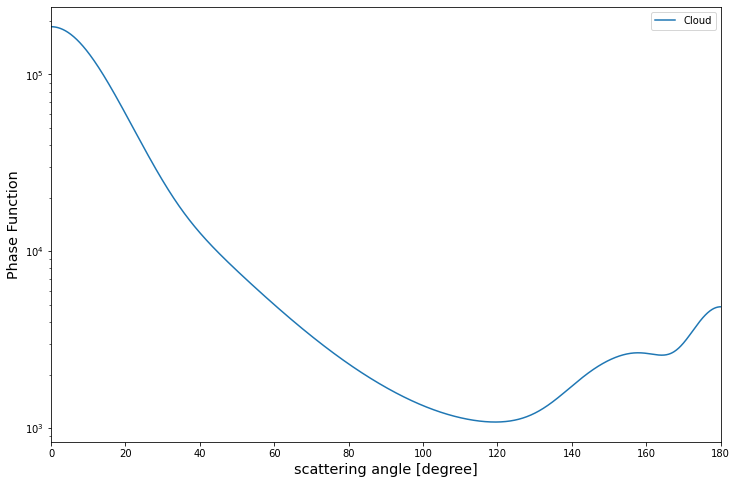

In [ ]:
from numpy.core.fromnumeric import size
Cloud_Qe = np.zeros_like(Cloud_SS.Nr)
Cloud_SSA=np.zeros_like(Cloud_SS.Nr)
Cloud_P11=np.zeros([Cloud_SS.Nr.size,Cloud_SS.Ang.size])
Cloud_Csca_P11 = np.zeros(Cloud_SS.Ang.size)
G=np.trapz(np.pi*cloud_PSD.r**2*cloud_PSD.dN_dr,cloud_PSD.r)
for i in range(Cloud_SS.Nr.size):
  Cloud_Cext=np.trapz(Cloud_SS.Qe[:,i]*np.pi*cloud_PSD.r**2*cloud_PSD.dN_dr,
                       cloud_PSD.r)
  Cloud_Csca=np.trapz(Cloud_SS.SSA[:,i]*Cloud_SS.Qe[:,i]*np.pi*cloud_PSD.r**2*cloud_PSD.dN_dr,
                       cloud_PSD.r)/Cloud_Cext
  for iang in range(Cloud_SS.Ang.size):
    Cloud_Csca_P11[iang]=np.trapz(Cloud_SS.P11[:,i,iang]*Cloud_SS.Qe[:,i]*
                                  Cloud_SS.Qe[:,i]*np.pi*cloud_PSD.r**2*cloud_PSD.dN_dr,
                                  cloud_PSD.r)
  Cloud_P11[i,:]=Cloud_Csca_P11/Cloud_Csca
  Cloud_SSA[i]=np.trapz(Cloud_SS.SSA[:,i]*Cloud_SS.Qe[:,i]*cloud_PSD.r**2*cloud_PSD.dN_dr,
                       cloud_PSD.r)/Cloud_Cext
  Cloud_Qe[i]= Cloud_Cext/G
  cloud_P11 = np.squeeze(Cloud_P11)

print(Cloud_Qe)
print(Cloud_SSA)
print(Cloud_P11.shape)
print(cloud_P11.shape)
wl=[0.5]
fig,ax=plt.subplots(figsize=(12, 8))
for i in range(Cloud_SS.Nr.size):
  ax.plot(Cloud_SS.Ang,Cloud_P11[i,:],label=r'Cloud'.format(wl[i]))
ax.set_yscale('log')
ax.set_xlabel('scattering angle [degree]',fontsize='x-large')
ax.set_ylabel('Phase Function',fontsize='x-large')
ax.set_xlim([0,180])
#ax.set_title('Polarized phase function vs scattering angle',fontsize='x-large')
ax.legend()

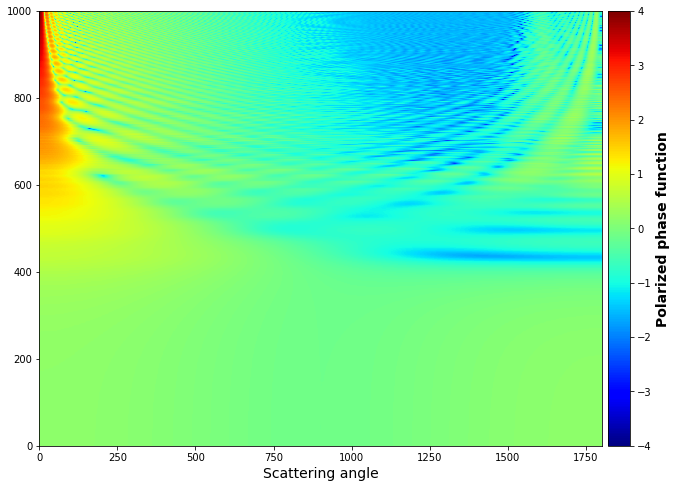

In [ ]:
fig,ax=plt.subplots(figsize=(12, 8))
#cf2 = ax.imshow(np.log10(Cloud_SS.P11[:,0,:]),cmap='jet')
cf2 = ax.pcolormesh(np.log10(Cloud_SS.P11[:,0,:]),cmap='jet', vmin = -4, vmax = 4)
cbar = fig.colorbar(cf2, ax=ax, pad=0.01)
cbar.set_label(label=r"Polarized phase function", size=14, weight="bold")
#ax.set_ylabel("Polarized phase function", fontsize=14)
ax.set_xlabel('Scattering angle', fontsize=14)
#plt.title("Polarized phase function vs scattering angle", fontsize=16)
#fig.colorbar(cf2,ax=ax)
plt.show()

In [ ]:
#Cloud optical thickness
heigth = 150
tau_cloud = 3.142*1e-6*Cloud_Qe*Nc*(reff**2)*heigth
print(tau_cloud)

[0.49090967]


In [ ]:
#Optical properties of mixture of cloud and aerosol
tau_mix = tau440 + tau_cloud
albedo_mix = ((smoke_alb*tau440) + (tau_cloud*Cloud_SSA))/tau_mix
P11_mix = ((smoke_P11*smoke_alb*tau440) + (cloud_P11*tau_cloud*Cloud_SSA))/((smoke_alb*tau440) + (tau_cloud*Cloud_SSA))
print(tau_mix)
print(albedo_mix)
print(P11_mix.shape)

[0.8709097]
[0.60567325]
(1801,)


(0.0, 180.0)

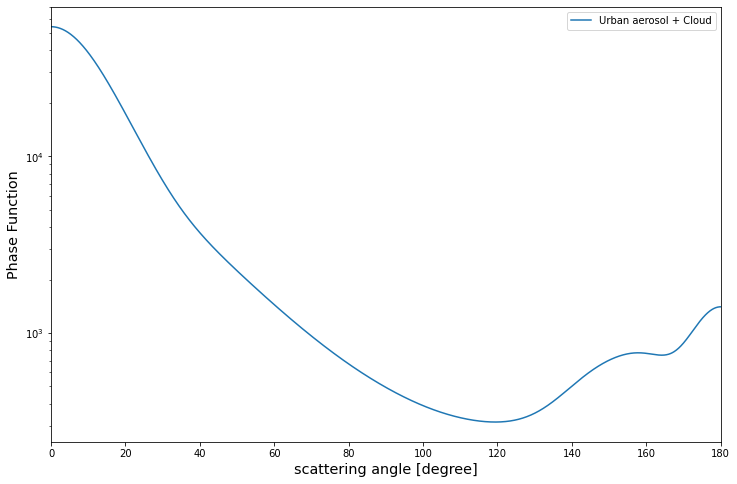

In [ ]:
fig,ax=plt.subplots(figsize=(12, 8))
ax.plot(Smoke_SS.Ang,P11_mix,label="Urban aerosol + Cloud")
plt.legend()
ax.set_yscale('log')
ax.set_xlabel('scattering angle [degree]',fontsize='x-large')
ax.set_ylabel('Phase Function',fontsize='x-large')
ax.set_xlim([0,180])
#ax.set_title('Polarized phase function vs scattering angle',fontsize='x-large')

## compute Reflectance based on single scattering approximation

In [ ]:
def compute_ScaAng(mu0,phi0,muv,phiv):
  '''
  compute the scattering angle based on
  mu0: cosine of solar zenith angle
  phi0: solar azimuth angle
  muv: cosine of viewing zenith angle
  phiv: viewing azimuth angle
  '''
  # first convert the solar angles to direction of sunlight
  mu_sl=-mu0
  phi_sl=np.pi+phi0
  mus = np.zeros((len(phiv),len(muv)))
  for i in range(len(phiv)):
    for j in range(len(muv)):
      mus[i,j] = mu_sl*muv[j]+np.sqrt(1-mu_sl**2)*np.sqrt(1-muv[j]**2)*np.cos(phiv[i]-phi_sl)
  return np.arccos(mus)

In [ ]:
mu0 = 0.5
phi0 = np.radians(120)

vza=np.deg2rad(np.linspace(0,90,90))
muv = np.cos(vza)
phiv = np.radians(np.linspace(0,360,60))

ScaAng = compute_ScaAng(mu0,phi0,muv,phiv)


<Figure size 720x720 with 0 Axes>

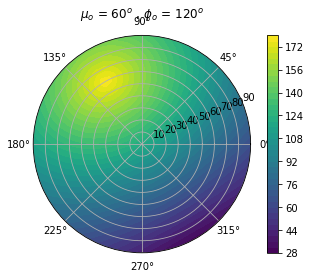

In [ ]:
r, theta = np.meshgrid(np.rad2deg(vza), phiv)
fig = plt.figure(figsize= (10,10))
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
cf=ax.contourf(theta, r, np.rad2deg(ScaAng),levels=40)
ax.set_title(r"${\mu_o}$ = $60^o$ , ${\phi_o}$ = $120^o$")
fig.colorbar(cf,ax=ax)
fig.savefig("./Scattering_Angle.png",dpi = 300)
plt.show()

In [ ]:
from re import RegexFlag
def Single_Scattering_App(Tau,Alb,Ang,P11,Rs,mu0,phi0,muv,phiv,F0=1):
  '''
  Compute the reflectnace and Transmittance of a scattering layer with
  Tau: optical depth
  Alb: Single scattering albedo
  P11: phase function
  Ang: the scattering angle corresponding to P11
  Rs: Lambertian surface reflectance
  mu0: cosine of solar zenith angle
  phi0: solar azimuth angle
  muv: cosine of viewing zenith angle
  phiv: viewing azimuth angle
  '''

  ScaAng = compute_ScaAng(mu0,phi0,muv,phiv)
  Ref = np.zeros((len(phiv),len(muv)))

  for i in range(len(phiv)):
    for j in range(len(muv)):
      T2 = np.exp(-Tau*(1/mu0+1/muv[j]))
      Air_mass=mu0/(mu0+muv[j])*(1-T2)
      surface_contribution = mu0*F0/np.pi*Rs*T2
      P11_at_scattering_angle= np.interp(np.rad2deg(ScaAng[i,j]),Ang,P11)
      #print(P11_at_scattering_angle)
      layer_contribution = F0*Alb/4/np.pi * Air_mass*P11_at_scattering_angle
      Ref[i,j] = surface_contribution + layer_contribution

  return Ref
#  return Ref*np.pi/mu0/F0

In [ ]:
Tau=tau_mix
mu0 = 0.5
phi0 = np.radians(120)
F0 = 1

vza=np.deg2rad(np.linspace(0,90,90))
muv = np.cos(vza)
phiv = np.radians(np.linspace(0,360,60))
Rs=0.0
Ref_smoke = Single_Scattering_App(Tau,albedo_mix,Smoke_SS.Ang,P11_mix,Rs,mu0,phi0,muv,phiv)

In [ ]:
#cloud only
Tau2=tau_cloud
mu0 = 0.5
F0 = 1
phi0 = np.radians(120)

vza=np.deg2rad(np.linspace(0,90,90))
muv = np.cos(vza)
phiv = np.radians(np.linspace(0,360,60))
Rs=0.0
Ref_cloud = Single_Scattering_App(Tau2,Cloud_SSA,Smoke_SS.Ang,cloud_P11,Rs,mu0,phi0,muv,phiv)

<Figure size 720x720 with 0 Axes>

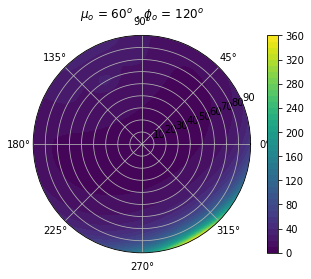

In [ ]:
r, theta = np.meshgrid(np.rad2deg(vza), phiv)
fig = plt.figure(figsize= (10,10))
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
cf=ax.contourf(theta, r, Ref_smoke ,levels=40)
ax.set_title(r"${\mu_o}$ = $60^o$ , ${\phi_o}$ = $120^o$")
fig.colorbar(cf,ax=ax)
fig.savefig("./TOS_Ref.png",dpi = 300)
plt.show()

<Figure size 720x720 with 0 Axes>

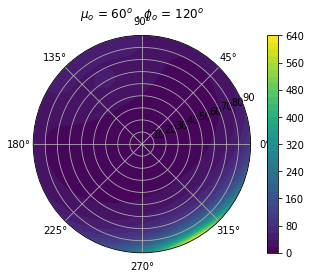

In [ ]:
#Cloud only
r, theta = np.meshgrid(np.rad2deg(vza), phiv)
fig = plt.figure(figsize= (10,10))
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
cf=ax.contourf(theta, r, Ref_cloud ,levels=40)
ax.set_title(r"${\mu_o}$ = $60^o$ , ${\phi_o}$ = $120^o$")
fig.colorbar(cf,ax=ax)
fig.savefig("./TOS_Ref.png",dpi = 300)
plt.show()

<Figure size 720x720 with 0 Axes>

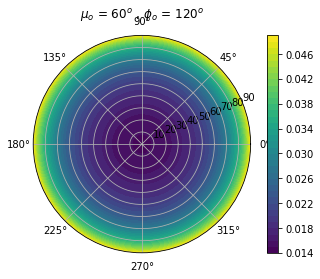

In [ ]:
isotropic_P11=np.ones_like(Smoke_SS.Ang)
#print(smoke_alb)
Ref_isotropic = Single_Scattering_App(Tau,albedo_mix,Smoke_SS.Ang,isotropic_P11,Rs,mu0,phi0,muv,phiv)

r, theta = np.meshgrid(np.rad2deg(vza), phiv)
fig = plt.figure(figsize= (10,10))
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
cf=ax.contourf(theta, r, Ref_isotropic ,levels=40)
ax.set_title(r"${\mu_o}$ = $60^o$ , ${\phi_o}$ = $120^o$")
fig.colorbar(cf,ax=ax)
fig.savefig("./TOS_Ref.png",dpi = 300)
plt.show()

<Figure size 720x720 with 0 Axes>

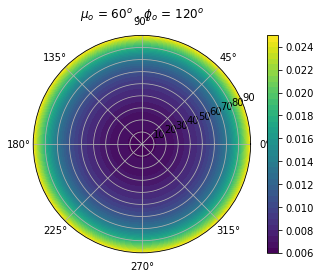

In [ ]:
#cloud
isotropic_P11=np.ones_like(Smoke_SS.Ang)
#print(smoke_alb)
Ref_isotropic2 = Single_Scattering_App(Tau2,Cloud_SSA,Smoke_SS.Ang,isotropic_P11,Rs,mu0,phi0,muv,phiv)

r, theta = np.meshgrid(np.rad2deg(vza), phiv)
fig = plt.figure(figsize= (10,10))
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
cf=ax.contourf(theta, r, Ref_isotropic2 ,levels=40)
ax.set_title(r"${\mu_o}$ = $60^o$ , ${\phi_o}$ = $120^o$")
fig.colorbar(cf,ax=ax)
fig.savefig("./TOS_Ref.png",dpi = 300)
plt.show()

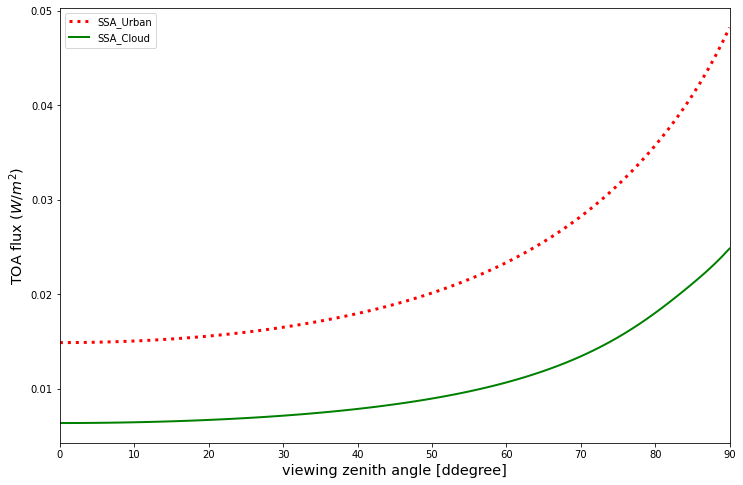

In [ ]:
fig,ax=plt.subplots(figsize=(12, 8))
ax.plot(np.rad2deg(vza),Ref_isotropic.mean(axis=0),lw=3,ls='dotted',c='r',label='SSA_Urban')
ax.plot(np.rad2deg(vza),Ref_isotropic2.mean(axis=0),lw=2,c='g',label='SSA_Cloud')
ax.set_xlabel('viewing zenith angle [ddegree]',fontsize='x-large')
ax.set_ylabel('TOA flux $(W/m^2)$',fontsize='x-large')
ax.set_xlim(0,90)
ax.legend()

In [ ]:
smoke_data = np.stack((Smoke_PSD.r, Smoke_PSD.dV_dlnr), axis=1)
psd_smoke = pd.DataFrame(smoke_data, columns= ['radius', 'PSD dV_dlnr (urban)'])
#print(psd_smoke)

#The data is exported for use in the modelling section
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/My Drive/psd_urban.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  psd_smoke.to_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cloud_data = np.stack((cloud_PSD.r, cloud_PSD.dN_dr), axis=1)
psd_cloud = pd.DataFrame(cloud_data, columns= ['radius', 'PSD dN_dr'])
#print(psd_cloud)
drive.mount('/content/drive')
path = '/content/drive/My Drive/psd_cloud.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  psd_cloud.to_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Smoke_SS.Ang,smoke_P11
p11smoke_data = np.stack((Smoke_SS.Ang, smoke_P11), axis=1)
p11_smoked = pd.DataFrame(p11smoke_data, columns= ['Angle', 'P11_urban'])
#print(p11_smoked)
drive.mount('/content/drive')
path = '/content/drive/My Drive/p11_urban.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  p11_smoked.to_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Cloud_SS.Ang,Cloud_P11[i,:]
p11cloud_data = np.stack((Cloud_SS.Ang, cloud_P11), axis=1)
p11_clouded = pd.DataFrame(p11cloud_data, columns= ['Angle', 'P11_cloud'])
#print(p11_clouded)
drive.mount('/content/drive')
path = '/content/drive/My Drive/p11_cloud.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  p11_clouded.to_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Smoke_SS.Ang,P11_mix
p11cloud_smoke_data = np.stack((Smoke_SS.Ang, P11_mix), axis=1)
p11_cloud_smoke = pd.DataFrame(p11cloud_smoke_data, columns= ['Angle', 'P11_cloud_urban'])
#print(p11_cloud_smoke)
drive.mount('/content/drive')
path = '/content/drive/My Drive/p11_cloud_urban.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  p11_cloud_smoke.to_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#np.rad2deg(vza), Ref_isotropic, Ref_isotropic2
flux_cloud_smoke_data = np.stack((np.rad2deg(vza), Ref_isotropic.mean(axis=0), Ref_isotropic2.mean(axis=0)), axis=1)
flux_cloud_smoke = pd.DataFrame(flux_cloud_smoke_data, columns= ['View angle', 'Flux urban38', 'Flux cloud'])
#print(flux_cloud_smoke)
drive.mount('/content/drive')
path = '/content/drive/My Drive/flux_cloud_urban38.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  flux_cloud_smoke.to_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
